# Capstone project

For this project you'll dig into a large amount of text and apply most of what you've covered in this unit and in the course so far.

First, pick a set of texts. This can be either a series of novels, chapters, or articles. Anything you'd like. It just has to have multiple entries of varying characteristics. At least 100 should be good. There should also be at least 10 different authors, but try to keep the texts related (either all on the same topic of from the same branch of literature - something to make classification a bit more difficult than obviously different subjects).

This capstone can be an extension of your NLP challenge if you wish to use the same corpus. If you found problems with that data set that limited your analysis, however, it may be worth using what you learned to choose a new corpus. Reserve 25% of your corpus as a test set.

The first technique is to create a series of clusters. Try several techniques and pick the one you think best represents your data. Make sure there is a narrative and reasoning around why you have chosen the given clusters. Are authors consistently grouped into the same cluster?

Next, perform some unsupervised feature generation and selection using the techniques covered in this unit and elsewhere in the course. Using those features then build models to attempt to classify your texts by author. Try different permutations of unsupervised and supervised techniques to see which combinations have the best performance.

Lastly return to your holdout group. Does your clustering on those members perform as you'd expect? Have your clusters remained stable or changed dramatically? What about your model? Is it's performance consistent?

If there is a divergence in the relative stability of your model and your clusters, delve into why.

Your end result should be a write up of how clustering and modeling compare for classifying your texts. What are the advantages of each? Why would you want to use one over the other? Approximately 3-5 pages is a good length for your write up, and remember to include visuals to help tell your story!

# Data cleaning / processing / language parsing

For this capstone project we will be using a dataset of papers from the 2015 NIPS conference, found on Kaggle.

https://www.kaggle.com/benhamner/nips-2015-papers

The text content of each paper is contained in Papers.csv, while the author information is provided in Authors.csv. We will need to merge the two datasets based on a common author ID value before we can do any data cleaning/processing.

In [333]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
import json
from time import time
from collections import Counter
from sklearn import ensemble
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import scikitplot.plotters as skplt

stopwords = stopwords.words('english')

#nltk.download('product_reviews_1')
#nltk.download('product_reviews_2')
#!python -m spacy download en

print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('Seaborn version:', sns.__version__)

Numpy version: 1.16.4
Pandas version: 0.23.4
Seaborn version: 0.9.0


In [334]:
df = pd.read_csv('datasets/all-the-news/articles1.csv')
#df = df[['title', 'author', 'text']]
#df.columns = ['Title', 'Author', 'Text']
df.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [335]:
df.isnull().sum()

Unnamed: 0         0
id                 0
title              0
publication        0
author          6306
date               0
year               0
month              0
url            50000
content            0
dtype: int64

In [336]:
df = df.drop(['Unnamed: 0', 'url'], axis=1)
df.head()

,id,title,publication,author,date,year,month,content
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,WASHINGTON — Congressional Republicans have...
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,"After the bullet shells get counted, the blood..."
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,"Death may be the great equalizer, but it isn’t..."
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,"SEOUL, South Korea — North Korea’s leader, ..."


In [337]:
df.isnull().sum()

id                0
title             0
publication       0
author         6306
date              0
year              0
month             0
content           0
dtype: int64

In [338]:
df = df.dropna()
df.head()

,id,title,publication,author,date,year,month,content
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,WASHINGTON — Congressional Republicans have...
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,"After the bullet shells get counted, the blood..."
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,"Death may be the great equalizer, but it isn’t..."
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,"SEOUL, South Korea — North Korea’s leader, ..."


Statistical Summary of Article Lengths
count     43694.000000
mean       3853.685197
std        3894.493670
min           1.000000
25%        1672.000000
50%        2810.500000
75%        5046.750000
max      149346.000000
dtype: float64


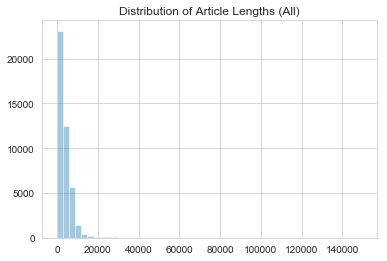

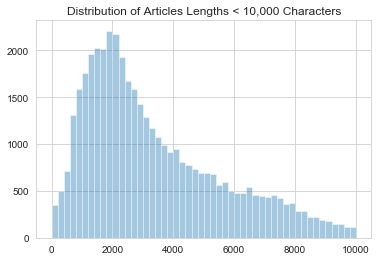

In [339]:
lengths = pd.Series([len(x) for x in df.content])
print('Statistical Summary of Article Lengths')
print(lengths.describe())

sns.distplot(lengths,kde=False)
plt.title('Distribution of Article Lengths (All)')
plt.show()
sns.distplot(lengths[lengths<10000],kde=False)
plt.title('Distribution of Articles Lengths < 10,000 Characters')
plt.show()

In [340]:
df.describe()

,id,year,month
count,43694.000000,43694.000000,43694.000000
mean,42122.658283,2016.314666,5.484895
std,15340.887303,0.563555,3.351943
min,17283.000000,2012.000000,1.000000
25%,29695.250000,2016.000000,3.000000
50%,40632.500000,2016.000000,5.000000
75%,52731.750000,2017.000000,8.000000
max,73469.000000,2017.000000,12.000000


In [341]:
lengths.describe()

count     43694.000000
mean       3853.685197
std        3894.493670
min           1.000000
25%        1672.000000
50%        2810.500000
75%        5046.750000
max      149346.000000
dtype: float64

In [342]:
# Add lengths column to main dataframe
df['length'] = lengths
df.head()

,id,title,publication,author,date,year,month,content,length
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,WASHINGTON — Congressional Republicans have...,5607.0
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,"After the bullet shells get counted, the blood...",27834.0
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,"When Walt Disney’s “Bambi” opened in 1942, cri...",14018.0
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,"Death may be the great equalizer, but it isn’t...",12274.0
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,"SEOUL, South Korea — North Korea’s leader, ...",4195.0


In [343]:
df.isnull().sum()

id                0
title             0
publication       0
author            0
date              0
year              0
month             0
content           0
length         4648
dtype: int64

In [344]:
# Filter out articles not within a specific range
#df = df[df['length'] > 5000]
#df.head()

In [345]:
# First ten authors with more than X articles
print(df.author.value_counts()[df.author.value_counts()>100][-100:])

Breitbart News               1559
Pam Key                      1282
Charlie Spiering              928
Jerome Hudson                 806
John Hayward                  747
Daniel Nussbaum               735
AWR Hawkins                   720
Ian Hanchett                  647
Joel B. Pollak                624
Alex Swoyer                   604
Warner Todd Huston            545
Jeff Poor                     505
Trent Baker                   457
Breitbart London              447
Katherine Rodriguez           435
Charlie Nash                  421
Ben Kew                       373
Frances Martel                366
Bob Price                     340
Dr. Susan Berry               333
Allan Smith                   311
Aaron Klein                   310
Breitbart Jerusalem           308
Thomas D. Williams, Ph.D.     305
Dan Riehl                     286
Lucas Nolan                   272
Patrick Howley                259
Matthew Boyle                 257
Tom Ciccotta                  256
Michelle Moons

In [346]:
# Make a DataFrame with articles by our chosen authors
# Include author names and article titles.

# Make a list of the 10 chosen author names
names = df.author.value_counts()[df.author.value_counts()>100][-100:].index.tolist()

print(names)

#names.remove('Breitbart London')

#print(names)

# DataFrame for articles of all chosen authors
data = pd.DataFrame()
for name in names:
    # Select each author's data
    articles = df[df.author==name][:100][['title','content','author']]
    # Append it to the DataFrame
    data = data.append(articles)

print(data.head())
    
data = data.reset_index().drop('index', 1)
    
data.head()

['Breitbart News', 'Pam Key', 'Charlie Spiering', 'Jerome Hudson', 'John Hayward', 'Daniel Nussbaum', 'AWR Hawkins', 'Ian Hanchett', 'Joel B. Pollak', 'Alex Swoyer', 'Warner Todd Huston', 'Jeff Poor', 'Trent Baker', 'Breitbart London', 'Katherine Rodriguez', 'Charlie Nash', 'Ben Kew', 'Frances Martel', 'Bob Price', 'Dr. Susan Berry', 'Allan Smith', 'Aaron Klein', 'Breitbart Jerusalem', 'Thomas D. Williams, Ph.D.', 'Dan Riehl', 'Lucas Nolan', 'Patrick Howley', 'Matthew Boyle', 'Tom Ciccotta', 'Michelle Moons', 'Adelle Nazarian', 'Chris Tomlinson', 'Pamela Engel', 'Liam Deacon', 'Katie McHugh', 'John Binder', 'Neil Munro', 'Edwin Mora', 'Neil W. McCabe', 'Maxwell Tani', 'Eric Bradner', 'Jeremy Diamond', 'Breitbart TV', 'Julia Hahn', 'Donna Rachel Edmunds', 'Emanuella Grinberg', 'Breitbart Tech', 'Natasha Bertrand', 'Mark Abadi', 'Chriss W. Street', 'Virginia Hale', 'Nate Church', 'Oliver JJ Lane', 'Allum Bokhari', 'Deborah Danan', 'Caroline May', 'Michael Patrick Leahy', 'Nick Hallett', 

,title,content,author
0,NYT: Immigration Hard-Liners Rising in Trump A...,Advocates who want America’s immigration laws ...,Breitbart News
1,Trump: Press Lying About Inauguration Crowd Si...,This story first appeared on Fox 5 New York: ...,Breitbart News
2,Report: Anti-Trump Hollywood Wins Big with Pre...,"In a column for the Hollywood Reporter, Senior...",Breitbart News
3,Breitbart News Daily: Terror in Manchester - B...,On the Tuesday edition of Breitbart News Daily...,Breitbart News
4,Rush Limbaugh on Obamacare 2.0: ’Why Do the Re...,Conservative radio host Rush Limbaugh question...,Breitbart News


In [347]:
# Look for duplicates
print('Number of articles:', data.shape[0])
print('Unique articles:', len(np.unique(data.index)))

# Number of authors
print('Unique authors:', len(np.unique(data.author)))
print('')
print('Articles by author:\n')

# Articles counts by author
print(data.author.value_counts())

Number of articles: 8600
Unique articles: 8600
Unique authors: 86

Articles by author:

Bob Price                    100
Adelle Nazarian              100
Matthew Boyle                100
Matt Weinberger              100
Breitbart Tech               100
Virginia Hale                100
Lisa Respers France          100
Cartel Chronicles            100
Edwin Mora                   100
Lucas Nolan                  100
Laura Smith-Spark            100
Michael Patrick Leahy        100
Julia Hahn                   100
Dr. Susan Berry              100
Thomas D. Williams, Ph.D.    100
Joel B. Pollak               100
Pam Key                      100
Deborah Danan                100
Emanuella Grinberg           100
Daniella Diaz                100
Katherine Rodriguez          100
Charlie Nash                 100
Daniel Nussbaum              100
Breitbart News               100
Chris Tomlinson              100
Ben Kew                      100
Oliver JJ Lane               100
Raheem Kassam        

In [348]:
start = time()

# Load spacy NLP object
nlp = spacy.load('en')

# A list to store common words by all authors
common_words = []

# A dictionary to store the spacy_doc object of each author
authors_docs = {}

for name in names:
    # Corpus is all the text written by that author
    corpus = ""
    
    # Grab all rows of current author, along the 'content' column
    author_content = data.loc[data.author == name, 'content']
    
    # Merge all articles in to the author's corpus
    for article in author_content:
        corpus = corpus + article
        
    # Let Spacy parse the author's body of text
    doc = nlp(corpus)
    
    # Store the doc in the dictionary
    authors_docs[name] = doc
        
    # Filter out punctuation and stop words.
    lemmas = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop]
        
    # Return the most common words of that author's corpus.
    bow = [item[0] for item in Counter(lemmas).most_common(1000)]
    
    # Add them to the list of words by all authors.
    for word in bow:
        common_words.append(word)

# Eliminate duplicates
common_words = set(common_words)
    
print('Total number of common words:', len(common_words))
print("done in %0.3fs" % (time() - start))

Total number of common words: 9794
done in 982.183s


In [349]:
# Let's see our 10 authors in the dictionary
lengths = []
for k,v in authors_docs.items():
    print(k,'corpus contains', len(v), ' words.')
    lengths.append(len(v))

Breitbart News corpus contains 35430  words.
Pam Key corpus contains 22077  words.
Charlie Spiering corpus contains 29404  words.
Jerome Hudson corpus contains 46174  words.
John Hayward corpus contains 118996  words.
Daniel Nussbaum corpus contains 47128  words.
AWR Hawkins corpus contains 42680  words.
Ian Hanchett corpus contains 29782  words.
Joel B. Pollak corpus contains 66611  words.
Alex Swoyer corpus contains 29901  words.
Warner Todd Huston corpus contains 48861  words.
Jeff Poor corpus contains 42895  words.
Trent Baker corpus contains 18296  words.
Breitbart London corpus contains 49026  words.
Katherine Rodriguez corpus contains 33162  words.
Charlie Nash corpus contains 48917  words.
Ben Kew corpus contains 41155  words.
Frances Martel corpus contains 85967  words.
Bob Price corpus contains 71230  words.
Dr. Susan Berry corpus contains 81060  words.
Allan Smith corpus contains 104917  words.
Aaron Klein corpus contains 102681  words.
Breitbart Jerusalem corpus contains 25

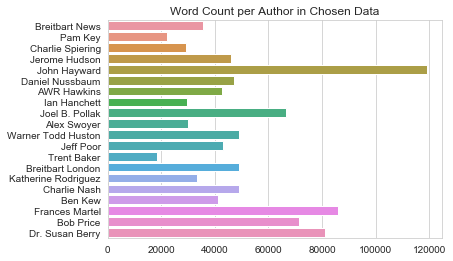

In [353]:
sns.barplot(x=lengths[:20], y=names[:20], orient='h')
plt.title('Word Count per Author in Chosen Data')
plt.show()

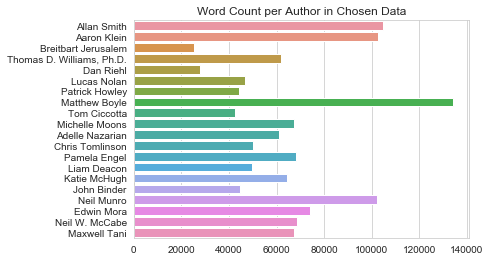

In [354]:
sns.barplot(x=lengths[20:40], y=names[20:40], orient='h')
plt.title('Word Count per Author in Chosen Data')
plt.show()

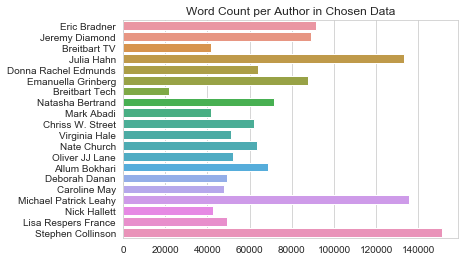

In [355]:
sns.barplot(x=lengths[40:60], y=names[40:60], orient='h')
plt.title('Word Count per Author in Chosen Data')
plt.show()

In [ ]:
# Choosing authors with similar word counts
authors = ['Jerome Hudson', 'Daniel Nussbaum', 'Warner Todd Huston', 'Charlie Nash', 'Chris Tomlinson', 
           'Liam Deacon', 'Virginia Hale', 'Oliver JJ Lane', 'Deborah Danan', 'Caroline May']


In [310]:
# check for lower case words
common_words = pd.Series(pd.DataFrame(columns=common_words).columns)
print('Count of all common_words:',len(common_words))
print('Count of lowercase common_words:',np.sum([word.islower() for word in common_words]))

# Turn all common_words into lower case
common_words = [word.lower() for word in common_words]
print('Count of lowercase common_words (After Conversion):', np.sum([word.islower() for word in common_words]))

Count of all common_words: 3973
Count of lowercase common_words: 2532
Count of lowercase common_words (After Conversion): 3875


In [315]:
# We must remove these in to avoid conflicts with existing features.
if 'author' in common_words:
    common_words.remove('author')
if 'title' in common_words:
    common_words.remove('title')
if 'content' in common_words:
    common_words.remove('content')

In [318]:
# Count the number of times a common_word appears in each article
# (about 3Hrs processing)

bow_counts = pd.DataFrame()
for name in names:
    # Select X articles of that author
    articles = data.loc[data.author==name,:][:50]
    bow_counts = bow_counts.append(articles)
bow_counts = bow_counts.reset_index().drop('index',1)

# Use common_words as the columns of a temporary DataFrame
df = pd.DataFrame(columns=common_words)

print(df.head())

# Join BOW features with the author's content
bow_counts = bow_counts.join(df)

# Initialize rows with zeroes
bow_counts.loc[:,common_words] = 0

print(bow_counts)

# Fill the DataFrame with counts of each feature in each article
start = time()
for i, article in enumerate(bow_counts.content):
    doc = nlp(article)
    for token in doc:
        if token.lemma_.lower() in common_words:
            bow_counts.loc[i,token.lemma_.lower()] += 1
    # Print a message every X articles
    if i % 50 == 0:
        if time()-start < 3600: # if less than an hour in seconds
            print("Article ",i," done after ",(time()-t0)/60,' minutes.')
        else:
            print("Article ",i," done after ",(time()-t0)/60/60,' hours.')

Empty DataFrame
Columns: [peace, barack, half, 25, gun, moore, variety, acquire, charge, johnson, hatred, mortensen, simply, public, hampshire, suffer, manage, single, 14, deficit, fist, reaction, guess, rich, @ianhanchettdemocratic, expand, perry, indiscriminate, authority, rodman, sheriff, nationwide, entrepreneurs, industry, radio, cooking, transition, party, painfully, conceal, council, ft, tampa, mainstream, provide, hate, sailor, shelter, manziel, time, recommend, dim, peter, giffords, disband,  , joke, network, right, theory, @megynkelly, definitely, age, knowledge, sympathy, song, rig, option, committee, minor, ideologist, sufficient, klug, matthew, states, pop, goodell, chairman, 1, grant, listen, failure, completely, squid, vp, google, bruise, attendance, official, drive, amazon, reince, usual, silicon, miller, @nytimes, u., quarter, boehner, democrats, ...]
Index: []

[0 rows x 3970 columns]
Empty DataFrame
Columns: [title, content, author, peace, barack, half, 25, gun, moor

In [ ]:
bow_counts.head(3)

In [ ]:
# Make sure we have 50 articles per author
bow_counts.author.value_counts()

In [ ]:
# Establish outcome and predictors
y = bow_counts['author']
X = bow_counts.drop(['content','author','title'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.24,
                                                    random_state=0,
                                                    stratify=y)


# Create features using two different NLP methods: For example, BoW vs tf-idf.

## BoW with CountVectorizer

# Tf-idf

# Use the features to fit supervised learning models for each feature set to predict the category outcomes.

## BoW with CountVectorizer
### Random Forest Classifier

### Logistic Regression

### Gradient Boosting Classifier

## Tf-idf
### Random Forest Classifier

### Logistic Regression

### Gradient Boosting Classifier

# Assess your models using cross-validation and determine whether one model performed better.

## BoW with CountVectorizer
### Random Forest Classifier

### Logistic Regression

### Gradient Boosting Classifier

## Tf-idf
### Random Forest Classifier

### Logistic Regression

### Gradient Boosting Classifier

Logistic Regression with CountVectorizer turned out to be the best model, by far. There was a severe performance degradation using the Tf-idf method to create features, so clearly using Bag of Words method via CountVectorizer was a far superior method. We will stick to that for any pending analysis.

# Pick one of the models and try to increase accuracy by at least 5 percentage points.

## BoW with CountVectorizer

## Logistic Regression